# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

## Шаг 1. Откройте файл с данными и изучите общую информацию

Открою таблицу с данными по взятым кредитам и сохраню её в переменную data, воспользовавшись библиотекой pandas.

In [1]:
import pandas as pd                      # Импортирую библиотеку pandas
from collections import Counter          # Импортирую коллекцию Counter
from pymystem3 import Mystem             # Получу лемматизатора для слов на русском
m = Mystem()
from copy import deepcopy                # импортирую метод для сохранения data в data_new
import seaborn                           # импортию библиотеку seaborn и matplotlib для постройки графика
import matplotlib.pyplot as plt
data = pd.read_csv('/datasets/data.csv') # Переменная data хранит изначальную таблицу без изменений
display(data.head(10))                   # Выведу первые 10 строк

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


Проверю уникальные значения каждого столбца, чтобы обнаружить ошибки в данных.

### Столбец 'children'

In [2]:
display(data['children'].sort_values().unique()) # узнаю, есть ли в столбце 'children' некорректные значения

array([-1,  0,  1,  2,  3,  4,  5, 20])

Не может быть (-1) ребенок, 20 слишком много. Считаю, что ошибка носит случайный характер.

### Столбец 'days_employed'

In [3]:
display(data['days_employed'].isna().sum()) # узнаю есть ли NaN в столбце 'days_employed'

2174

Такое большое количество NaN указывает на неслучайных характер ошибки.

### Столбец 'dob_years'

In [4]:
display(data['dob_years'].sort_values().unique()) # узнаю, есть ли в столбце 'dob_years' некорректные значения

array([ 0, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75])

Не может быть возраст 0. Так как данное значение присутствует во многих местах, ошибка неслучайна, скорей всего возраст не был заполнен намеренно.

### Столбец 'education'

In [5]:
display(data['education'].sort_values().unique()) # узнаю, есть ли в столбце 'education' некорректные значения

array(['ВЫСШЕЕ', 'Высшее', 'НАЧАЛЬНОЕ', 'НЕОКОНЧЕННОЕ ВЫСШЕЕ',
       'Начальное', 'Неоконченное высшее', 'СРЕДНЕЕ', 'Среднее',
       'УЧЕНАЯ СТЕПЕНЬ', 'Ученая степень', 'высшее', 'начальное',
       'неоконченное высшее', 'среднее', 'ученая степень'], dtype=object)

Выбивающихся из контекста наименований нет. Различием в написании займусь позже.

### Столбец 'education_id'

In [6]:
display(data['education_id'].sort_values().unique()) # узнаю, есть ли в столбце 'education_id' некорректные значения

array([0, 1, 2, 3, 4])

Выбивающихся из контекста значений нет.

### Столбец 'family_status'

In [7]:
display(data['family_status'].sort_values().unique()) # узнаю, есть ли в столбце 'family_status' некорректные значения

array(['Не женат / не замужем', 'в разводе', 'вдовец / вдова',
       'гражданский брак', 'женат / замужем'], dtype=object)

Выбивающихся из контекста наименований нет. "Не женат" выбивается из общего стиля заглавной буквой.

### Столбец 'family_status_id'

In [8]:
display(data['family_status_id'].sort_values().unique()) # узнаю, есть ли в столбце 'family_status_id' некорректные значения

array([0, 1, 2, 3, 4])

Выбивающихся из контекста наименований нет

### Столбец 'gender'

In [9]:
display(data['gender'].sort_values().unique()) # узнаю, есть ли в столбце 'gender' некорректные значения

array(['F', 'M', 'XNA'], dtype=object)

Имеется значение 'XNA'. Скорей всего кто-то не ввел свой пол. Случайная ошибка.

### Столбец 'income_type'

In [10]:
display(data['income_type'].sort_values().unique()) # узнаю, есть ли в столбце 'income_type' некорректные значения

array(['безработный', 'в декрете', 'госслужащий', 'компаньон',
       'пенсионер', 'предприниматель', 'сотрудник', 'студент'],
      dtype=object)

Выбивающихся из контекста наименований нет.

### Столбец 'debt'

In [11]:
display(data['debt'].sort_values().unique()) # узнаю, есть ли в столбце 'debt' некорректные значения

array([0, 1])

Выбивающихся из контекста наименований нет.

### Столбец 'total_income'

In [12]:
display(data['total_income'].isna().sum()) # узнаю есть ли NaN в столбце 'total_income'

2174

Такое большое количество NaN указывает на неслучайных характер ошибки.

### Столбец 'purpose'

In [13]:
display(data['purpose'].sort_values().unique()) # узнаю, есть ли в столбце 'purpose' некорректные значения

array(['автомобили', 'автомобиль', 'высшее образование',
       'дополнительное образование', 'жилье',
       'заняться высшим образованием', 'заняться образованием',
       'на покупку автомобиля', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля', 'на проведение свадьбы',
       'недвижимость', 'образование', 'операции с жильем',
       'операции с коммерческой недвижимостью',
       'операции с недвижимостью', 'операции со своей недвижимостью',
       'покупка жилой недвижимости', 'покупка жилья',
       'покупка жилья для сдачи', 'покупка жилья для семьи',
       'покупка коммерческой недвижимости', 'покупка недвижимости',
       'покупка своего жилья', 'получение высшего образования',
       'получение дополнительного образования', 'получение образования',
       'приобретение автомобиля', 'профильное образование',
       'ремонт жилью', 'свадьба', 'свой автомобиль',
       'сделка с автомобилем', 'сделка с подержанным автомобилем',
       'строительство 

Выбивающихся из контекста наименований нет.

### Столбцы 'days_employed' и 'total_income'

Узнаю общие данные по таблице.

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


В столбцах days_employed и total_income имеются пропущенные значения, а также имеют тип данных float.

**Вывод**

При изучении столбцов таблицы установил следующее:
- столбец children содержит значения 20 и (-1);
- столбец days_employed содержит отрицательные значения, слишком большие значения, NaN;
- столбец dob_years в некоторых местах содержит 0;
- столбец education содержит разное написание одних и тех же слов;
- столбец education_id в порядке;
- столбец family_status имеет заглавную букву;
- столбец family_status_id в порядке;
- столбец gender в одном месте имеет значение XNA;
- столбец income_type в порядке;
- столбец debt в порядке;
- столбец total_income в некоторых местах содержит NaN;
- столбец purpose требует лемматизации, так как имеет различные формулировки одного и того же.

## Шаг 2. Предобработка данных

### Обработка пропусков

#### Cтолбец 'children'

Значение (-1) явно опечатка, имеется ввиду 1, также и 20 опечатка, скорей всего имеется ввиду 2.

In [15]:
data_new = deepcopy(data)                                  # на всякий случай все дальнейшие изменения буду вносить в новую таблицу
data_new['children'] = data_new['children'].replace(-1, 1) # заменю значения -1 на 1 в столбце 'children'
data_new['children'] = data_new['children'].replace(20, 2) # заменю значения 20 на 2 в столбце 'children'
display(data_new['children'].sort_values().unique())       # проверю всё ли получилось

array([0, 1, 2, 3, 4, 5])

#### Столбец 'days_employed'

Посторю график по "компаньону" и по "пенсионерам". Информация по таблице была следующая - в столбце days_employed указаны дни, поэтому разделю значения на 365, чтобы узнать года.

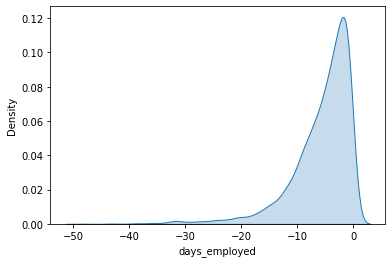

In [16]:
snsplot = seaborn.kdeplot(data['days_employed'][data['income_type'] == 'компаньон'] / 365, shade=True)
fig = snsplot.get_figure() # построю график с отрицательными значениями

Отрицательные значения укладываются в реально возможные (максимальный срок работы - 52-53 года).

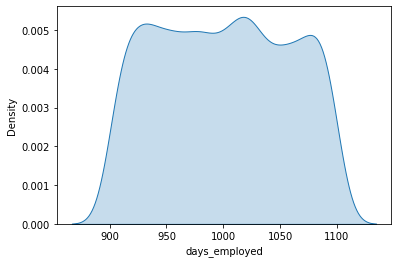

In [17]:
snsplot = seaborn.kdeplot(data['days_employed'][data['income_type'] == 'пенсионер'] / 365, shade=True)
fig = snsplot.get_figure() # теперь проверю как обстоят дела с пенсинерами

Получились невозможные значения.

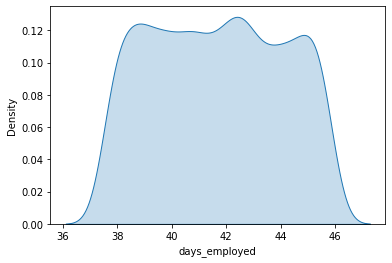

In [18]:
snsplot = seaborn.kdeplot(data['days_employed'][data['income_type'] == 'пенсионер'] / 8760, shade=True)
fig = snsplot.get_figure() # теперь проверю рабочий стаж песионеров в часах

Теперь значения близки к реальным, делаю вывод, что большие положительные значения даны в часах. Буду делить эти значения на 24 часа, чтобы получиться в таблице значения в днях.

Сделаю все значения положительными, а также переведу значения, указанные для пенсионеров из часов в дни.

In [19]:
def days_employed(row):    # функция позволит все значения столбца привести к положительным значениям и к дням
    if row > 0:
        row = row / 24
        return row
    elif row < 0:
        row = row*(-1)
        return row
    else:
        return row
    
data_new['days_employed'] = data_new['days_employed'].apply(days_employed) # заменю значения в столбце 'days_employed' новыми
display(data_new)                                                          # проверю замену

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,14177.753002,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
...,...,...,...,...,...,...,...,...,...,...,...,...
21520,1,4529.316663,43,среднее,1,гражданский брак,1,F,компаньон,0,224791.862382,операции с жильем
21521,0,14330.725172,67,среднее,1,женат / замужем,0,F,пенсионер,0,155999.806512,сделка с автомобилем
21522,1,2113.346888,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672.561153,недвижимость
21523,3,3112.481705,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093.050500,на покупку своего автомобиля


#### Столбец 'days_employed' и 'total_income'

Считаю, что по возрасту неполучится точно рассчитать количесвто отработанных дней и зарплату, тем более, что в столбце dob_years имеются нули. Заполню пропуски в столбцах days_employed и total_income опираясь на столбец income_type (и количество отработанных дней и уровень дохода в среднем должен соответствовать типу занятости).

In [20]:
display(data_new[data_new['days_employed'].isna()]['income_type'].unique()) # узнаю уникальные значения столбца income_type, соответствующие
                                                                            # пропускам в столбце days_employed

array(['пенсионер', 'госслужащий', 'компаньон', 'сотрудник',
       'предприниматель'], dtype=object)

Так как медиана оценивает среднее значение, нивелировав влияние выбросов буду использовать только её. Даже если у меня распределение близкое к стандартному медиана совпадет со средним арифметическим.
Расчитаю медиану значений столбца 'days_employed' по категориям работников.

In [21]:
gos_days_employed = data_new['days_employed'][data_new['income_type'] == 'госслужащий'] # медиана для госслужащего
gos_days_employed_median = gos_days_employed.median()

comp_days_employed = data_new['days_employed'][data_new['income_type'] == 'компаньон']  # медиана для компаньона
comp_days_employed_median = comp_days_employed.median()

pens_days_employed = data_new['days_employed'][data_new['income_type'] == 'пенсионер']  # медиана для пенсионера
pens_days_employed_median = pens_days_employed.median()

buss_days_employed = data_new['days_employed'][data_new['income_type'] == 'предприниматель'] # медиана для предпринимателя
buss_days_employed_median = buss_days_employed.median()

sotr_days_employed = data_new['days_employed'][data_new['income_type'] == 'сотрудник'] # медиана для сотрудника
sotr_days_employed_median = sotr_days_employed.median()

Расчитаю медиану значений столбца 'total_income' по категориям работников.

In [22]:
gos_total_income = data_new['total_income'][data_new['income_type'] == 'госслужащий'] # медиана для госслужащего
gos_total_income_median = gos_total_income.median()

comp_total_income = data_new['total_income'][data_new['income_type'] == 'компаньон'] # медиана для компаньона
comp_total_income_median = comp_total_income.median()

pens_total_income = data_new['total_income'][data_new['income_type'] == 'пенсионер'] # медиана для пенсионера
pens_total_income_median = pens_total_income.median()

buss_total_income = data_new['total_income'][data_new['income_type'] == 'предприниматель'] # медиана для предпринимателя
buss_total_income_median = buss_total_income.median()

sotr_total_income = data_new['total_income'][data_new['income_type'] == 'сотрудник'] # медиана для сотрудника
sotr_total_income_median = sotr_total_income.median()

Заполню пропущенные значения в столбцах 'days_employed' и 'total_income'

In [23]:
data_new['days_employed'] = data_new['days_employed'].fillna(0)  # заполню пропущенные значения нулями
data_new['total_income'] = data_new['total_income'].fillna(0)

dict_type = ['пенсионер', 'госслужащий', 'компаньон', 'сотрудник', 'предприниматель'] # соберу в список все типы занятости

def day_tot_median(row, dict_type):    # функция позволит заменить нули на значение медианы
    if row[1] == 0:
        if row[8] == dict_type[0]:
            row[1] = pens_days_employed_median
            row[10] = pens_total_income_median
            return row
        elif row[8] == dict_type[1]:
            row[1] = gos_days_employed_median
            row[10] = gos_total_income_median
            return row
        elif row[8] == dict_type[2]:
            row[1] = comp_days_employed_median
            row[10] = comp_total_income_median
            return row
        elif row[8] == dict_type[3]:
            row[1] = sotr_days_employed_median
            row[10] = sotr_total_income_median
            return row
        elif row[8] == dict_type[4]:
            row[1] = buss_days_employed_median
            row[10] = buss_total_income_median
            return row
    else:
        return row

data_new = data_new.apply(day_tot_median, axis=1, args=[dict_type]) # применю функцию
display(data_new['days_employed'].isna().sum()) # проверю наличие NaN
display(data_new['total_income'].isna().sum())

0

0

#### Столбец 'dob_years'

Данные столбца 'days_employed' не дают возможности заполнить отсутствующий возраст, так как сильно разнятся по одному значению. Возраст не влияет на результат исследования надежности заемщиков, поэтому заполню средними значениями. Так как возраст представляет собой практически нормальное распределение, считаю применение среднеднего арифметического оправданным.

In [24]:
# заполню столбец 'dob_years' средними значениями, вместо нулей
data_new['dob_years'] = data_new['dob_years'].replace(0, int(data_new['dob_years'][data_new['dob_years'] != 0].mean())) 

display(data_new['dob_years'][data_new['dob_years'] == 0].count()) # проверю остались ли нули в столбце 'dob_years'

0

#### Cтолбец 'gender'

Для начала изучу строчку, включающую 'XNA'.

In [25]:
display(data_new[data_new['gender'] == 'XNA'].head(10)) # выведу необходимую строчку

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
10701,0,2358.600502,24,неоконченное высшее,2,гражданский брак,1,XNA,компаньон,0,203905.157261,покупка недвижимости


Предположу, что с неоконченным высшим, в 24 года, с зарплатой 203905, брать кредит на покупку недвижимости в нашей стране может мужчина. 

In [26]:
data_new.loc[10701, 'gender'] = 'M' # укажу гендер М в соответствующем месте

display(data_new.loc[10701, 'gender']) # проверю все ли получилось

'M'

**Вывод**

После проведения обработки пропусков в данных я получил таблицу по которой смогу дать объективный ответ по всем вопросам данного исследования. Без проведения обработки пропусков итоговый результат был бы неточен.

### Замена типа данных

В столбцах 'days_employed' и 'total_income' тип данных float, может повлиять на операции с этими значениями. Приведу их к типу int так как округление не повлияет на итоговый результат исследования.

In [27]:
data_new['days_employed'] = data_new['days_employed'].astype('int') # приведу данные к типу int
data_new['total_income'] = data_new['total_income'].astype('int')
display(data_new.info()) # проверю тип данных в таблице

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   children          21525 non-null  int64 
 1   days_employed     21525 non-null  int64 
 2   dob_years         21525 non-null  int64 
 3   education         21525 non-null  object
 4   education_id      21525 non-null  int64 
 5   family_status     21525 non-null  object
 6   family_status_id  21525 non-null  int64 
 7   gender            21525 non-null  object
 8   income_type       21525 non-null  object
 9   debt              21525 non-null  int64 
 10  total_income      21525 non-null  int64 
 11  purpose           21525 non-null  object
dtypes: int64(7), object(5)
memory usage: 2.0+ MB


None

**Вывод**

Все числовые значения в таблице приведены к типу int, что упростит дальнейшее исследование, а также позволит избежать ошибок в вычислениях.

### Обработка дубликатов

После восстановления пропусков и приведения числовых данных в таблице к одному типу, необходимо проверить данные на наличие дубликатов.

In [28]:
data_new['education'] = data_new['education'].str.lower()         # приведу текст в столбце 'education' к нижнему регистру
data_new['family_status'] = data_new['family_status'].str.lower() # заодно избавлюсь от заглавной буквы
display(data_new.duplicated().sum())                              # найду количество дубликатов в данных

71

После нахождения дубликатов их необходимо удалить.

In [29]:
data_new = data_new.drop_duplicates() # удалю найденные дубликаты
display(data_new.duplicated().sum())  # проверю результат

0

**Вывод**

Найденные дубликаты удалены и не будут влиять на итоговый результат исследования.

### Лемматизация

Для целей исследования необходимо определить на что люди чаще всего берут кредит. Чтобы выявить основные слова в столбце 'purpose' использую лемматизацию.

In [30]:
purpose_unique = data_new['purpose'].unique() # определю уникальные значения в столбце purpose
purpose_unique = (" ".join(purpose_unique))   # соберу значения в список
lemmas = m.lemmatize(purpose_unique)          # применю метод m.lemmatize к списку
lemmas = " ".join(set(lemmas))                # соберу леммы в список
lemmas = sorted(list(lemmas.split()))         # отсортирую список
display(lemmas)                               # выведу список для ознакомления

['автомобиль',
 'высокий',
 'для',
 'дополнительный',
 'жилой',
 'жилье',
 'заниматься',
 'коммерческий',
 'на',
 'недвижимость',
 'образование',
 'операция',
 'подержать',
 'покупка',
 'получение',
 'приобретение',
 'проведение',
 'профильный',
 'ремонт',
 'с',
 'свадьба',
 'свой',
 'сдача',
 'сделка',
 'семья',
 'со',
 'собственный',
 'строительство',
 'сыграть']

**Вывод**

Из полученых лемм легко определить что чаще всего кредит берется на автомобиль, жилье, образование, свадьбу и ремонт. Считаю, что ремонт можно отнести к жилью. Лемматизация позволит категоризировать цель кредита, что поможет повысить надежность результата исследования.

### Категоризация данных

#### Столбец 'children'

Так как количество детей важная для исследования характеристика, то считаю необходимым сделать категоризацию по столбцу 'children'. В России семья, имеющая 1-2 ребенка считается малодетной, свыше 2 многодетной. Категории наличия детей следующие -'бездетная семья', 'малодетная семья', 'многодетная семья'.

In [31]:
def children_cat(row): # функция позволит возвращать категорию в зависимости от значения ячейки
    if row == 0:
        return 'бездетная семья'
    elif 0 < row < 3:
        return 'малодетная семья'
    else:
        return 'многодетная семья'
    
data_new['children_cat'] = data_new['children'].apply(children_cat) # применю функцию к столбцу 'children', с созданием нового столбца children_cat

display(data_new)                               # проверю результат
display(data_new['children_cat'].value_counts())

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,children_cat
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,малодетная семья
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,малодетная семья
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,бездетная семья
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,многодетная семья
4,0,14177,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,бездетная семья
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21520,1,4529,43,среднее,1,гражданский брак,1,F,компаньон,0,224791,операции с жильем,малодетная семья
21521,0,14330,67,среднее,1,женат / замужем,0,F,пенсионер,0,155999,сделка с автомобилем,бездетная семья
21522,1,2113,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672,недвижимость,малодетная семья
21523,3,3112,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093,на покупку своего автомобиля,многодетная семья


бездетная семья      14091
малодетная семья      6983
многодетная семья      380
Name: children_cat, dtype: int64

#### столбец 'total_income'

Так как ежемесячный доход важная для исследования характеристика, то считаю необходимым сделать категоризацию по столбцу 'total_income'. При категоризации буду отталкиваться от медианного значения по столбцу 'total_income' с шагом 50000.

In [32]:
display(data_new['total_income'].median()) # найду медиану по столбцу total_income

142594.0

In [33]:
def total_income_cat(row): # функция позволит вернуть категорию дохода, в зависимости от значения ячейки
    if row <= 100000:
        return 'доход до 100 тысяч'
    elif 100000 < row <= 150000:
        return 'доход от 100 до 150 тысяч'
    elif 150000 < row <= 200000:
        return 'доход от 150 до 200 тысяч' 
    elif 200000 < row <= 250000:
        return 'доход от 200 до 250 тысяч' 
    else:
        return 'доход от 250 тысяч'
    
data_new['total_income_cat'] = data_new['total_income'].apply(total_income_cat) # применю функцию к столбцу total_income с созданием нового столбца total_income_cat

display(data_new)                                     # проверю результат
display(data_new['total_income_cat'].value_counts())

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,children_cat,total_income_cat
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,малодетная семья,доход от 250 тысяч
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,малодетная семья,доход от 100 до 150 тысяч
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,бездетная семья,доход от 100 до 150 тысяч
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,многодетная семья,доход от 250 тысяч
4,0,14177,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,бездетная семья,доход от 150 до 200 тысяч
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21520,1,4529,43,среднее,1,гражданский брак,1,F,компаньон,0,224791,операции с жильем,малодетная семья,доход от 200 до 250 тысяч
21521,0,14330,67,среднее,1,женат / замужем,0,F,пенсионер,0,155999,сделка с автомобилем,бездетная семья,доход от 150 до 200 тысяч
21522,1,2113,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672,недвижимость,малодетная семья,доход до 100 тысяч
21523,3,3112,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093,на покупку своего автомобиля,многодетная семья,доход от 200 до 250 тысяч


доход от 100 до 150 тысяч    7160
доход от 150 до 200 тысяч    4764
доход до 100 тысяч           4463
доход от 250 тысяч           2813
доход от 200 до 250 тысяч    2254
Name: total_income_cat, dtype: int64

#### столбец 'purpose'

Так как цель кредита важная для исследования характеристика, то считаю необходимым сделать категоризацию по столбцу 'purpose'. При лемматизации я выявил основные цели взятия кредита, а именно: автомобиль, жилье, свадьба, образование. По этим значениям и буду категоризировать.

Соберу в словарь все ключевые слова по целям получения кредита на основе выполненной ранее лемматизации.

In [34]:
purpose_dict = {'свадьба', 'автомобиль', 'образование', 'жилой', 'жилье', 'собственный',  'коммерческий', 'недвижимость'} # создам новый словарь

Создам новый столбец 'purpose_id' с категорией цели взятия кредита на основе созданного словаря.

In [35]:
def set_purpose_cat(row, purpose_dict): # функция позволит вернуть значение по словарю в соответствии с лемматизированным значением в ячейке
    lemma = m.lemmatize(row)
    for word in lemma:
        if word in purpose_dict:
            return word

data_new['purpose_cat'] = data_new['purpose'].apply(set_purpose_cat, args=[purpose_dict]) # применю функцию к столбцу purpose с созданием нового столбца purpose_id 

display(data_new) # проверю результат

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,children_cat,total_income_cat,purpose_cat
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,малодетная семья,доход от 250 тысяч,жилье
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,малодетная семья,доход от 100 до 150 тысяч,автомобиль
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,бездетная семья,доход от 100 до 150 тысяч,жилье
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,многодетная семья,доход от 250 тысяч,образование
4,0,14177,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,бездетная семья,доход от 150 до 200 тысяч,свадьба
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21520,1,4529,43,среднее,1,гражданский брак,1,F,компаньон,0,224791,операции с жильем,малодетная семья,доход от 200 до 250 тысяч,жилье
21521,0,14330,67,среднее,1,женат / замужем,0,F,пенсионер,0,155999,сделка с автомобилем,бездетная семья,доход от 150 до 200 тысяч,автомобиль
21522,1,2113,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672,недвижимость,малодетная семья,доход до 100 тысяч,недвижимость
21523,3,3112,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093,на покупку своего автомобиля,многодетная семья,доход от 200 до 250 тысяч,автомобиль


Выполню проверку все ли строки таблицы оказались заполненны ключевыми словами (необходимо удостовериться, что ни в одной строке нет None.

In [36]:
display(data_new['purpose_cat'].value_counts().sum()) # выведу значения по количеству заполненных ячеек и их уникальным значениям
display(data_new['purpose_cat'].unique())

21454

array(['жилье', 'автомобиль', 'образование', 'свадьба', 'недвижимость',
       'коммерческий', 'жилой', 'собственный'], dtype=object)

Обнаружилось, что часть значений не заменилось на ключевые слова. Предположу, что в этих строках не встречается ни одного ключевого слова. Поэтому заменю значения None на цель кредита "другое".

Приведу столбец 'purpose_cat' к читаемому виду.

In [37]:
# заменю ключевые слова на общие
data_new['purpose_cat'] = data_new['purpose_cat'].replace(['жилье', 'операция', 'недвижимость', 'коммерческий', 'жилой', 'строительство', 'ремонт'], 'кредит на недвижимость')
data_new['purpose_cat'] = data_new['purpose_cat'].replace(['автомобиль', 'подержать', 'собственный'], 'кредит на автомобиль')
data_new['purpose_cat'] = data_new['purpose_cat'].replace(['дополнительный', 'образование', 'заниматься', 'получение', 'профильный'], 'кредит на образование')
data_new['purpose_cat'] = data_new['purpose_cat'].replace(['свадьба'], 'кредит на свадьбу')
# приведу None к NaN
pd.to_numeric(data_new['purpose_cat'], errors='coerce')
# заменю NaN на значение
data_new['purpose_cat'] = data_new['purpose_cat'].fillna(0)
data_new['purpose_cat'] = data_new['purpose_cat'].replace(0, 'другая цель кредита')
# проверю результат
display(data_new['purpose_cat'].value_counts().sum())
display(data_new['purpose_cat'].unique())

21454

array(['кредит на недвижимость', 'кредит на автомобиль',
       'кредит на образование', 'кредит на свадьбу'], dtype=object)

**Вывод**

Для достижения качественных результатов по исследованию столбцы 'children', 'total_income', 'purpose' категоризированны соответствующим образом. Столбцы 'debt', 'family_status' уже категоризированы.

## Шаг 3. Ответьте на вопросы

**Есть ли зависимость между наличием детей и возвратом кредита в срок?**

Сведу полученные данные в таблицу для наглядности.

In [38]:
data_child = deepcopy(data_new) # для составления таблиц из данных создам новую переменную
data_child.rename(columns={'children_cat': 'Категория семьи', 'debt': 'Всего долгов'}, inplace=True) # для наглядности в результатах таблицы буду выводить со столбцами на рукком языке
t_1 = pd.pivot_table(data_child, index='Категория семьи', values='Всего долгов', aggfunc='count') # создам таблицы с данными по выплаченным кредитам
t_2 = pd.pivot_table(data_child, index='Категория семьи', values='Всего долгов', aggfunc='sum')
dept_child = t_1
dept_child['Не выплачено долгов'] = t_2['Всего долгов']
dept_child['Выплачено долгов'] = dept_child['Всего долгов'] - dept_child['Не выплачено долгов']
dept_child['Процент выплаченных долгов'] = dept_child['Выплачено долгов'] / dept_child['Всего долгов']
dept_child['Процент выплаченных долгов'] = dept_child['Процент выплаченных долгов'].mul(100).round(1).astype(str).add('%') # переведу в проценты
dept_child = dept_child.sort_values(by='Процент выплаченных долгов', ascending=False) # отсортирую по убыванию
display(dept_child)

,Всего долгов,Не выплачено долгов,Выплачено долгов,Процент выплаченных долгов
Категория семьи,,,,
бездетная семья,14091,1063,13028,92.5%
многодетная семья,380,31,349,91.8%
малодетная семья,6983,647,6336,90.7%


Составлю график по процентам выплаченных долгов.

Text(0, 0.5, 'Категория семьи')

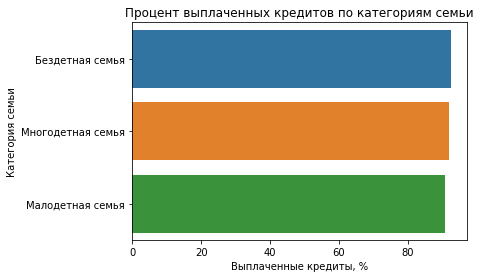

In [39]:
seaborn.barplot(y=['Бездетная семья', 'Многодетная семья', 'Малодетная семья'], x=[92.5, 91.8, 90.7]); # построю график по полученным значениям
plt.title('Процент выплаченных кредитов по категориям семьи') # оформлю график для наглядности
plt.xlabel('Выплаченные кредиты, %')
plt.ylabel('Категория семьи')

**Вывод**

По графику видно, что процент выплат по кредиту слабо зависит от количества детей в семье:
<br>
<br>
Для бездетной семьи - 92,5%
<br>
Для многодетной семьи - 91,8%
<br>
Для малодетной семьи - 90,7%
<br>

- Предположу, что в многодетных семьях все затраты (в том числе на выплату кредита) планируются более ответственно, чем в малодетных семьях. Плюс такие семьи часто имеют различные субсидии и выплаты, помогающие планировать расходы. В таких семьях не рискуют брать кредит, который в перспективе можно "не потянуть".
<br>
- В бездетных семьях вообще нет затрат связанных с ребенком, поэтому планировать бюджет в таких семьях можно максимально точно, учитывая все месячные расходы.
<br>
- В малодетных семьях самый низкий процент выплат по кредиту по причине того, что такие семьи ещё не учитывают непредвиденные расходы, связанные с детьми и планирование бюджета в таких самьях сопряжено с переоценкой своих возможностей. Возможно часть кредитов берется с определенным риском по возможностям погошения ежемесячных платежей.

**Есть ли зависимость между семейным положением и возвратом кредита в срок?**

Сведу полученные данные в таблицу для наглядности.

In [40]:
data_family = deepcopy(data_new)
data_family.rename(columns={'family_status': 'Семейное положение', 'debt': 'Всего долгов'}, inplace=True)
t_1 = pd.pivot_table(data_family, index='Семейное положение', values='Всего долгов', aggfunc='count')
t_2 = pd.pivot_table(data_family, index='Семейное положение', values='Всего долгов', aggfunc='sum')
dept_family = t_1
dept_family['Не выплачено долгов'] = t_2['Всего долгов']
dept_family['Выплачено долгов'] = dept_family['Всего долгов'] - dept_family['Не выплачено долгов']
dept_family['Процент выплаченных долгов'] = dept_family['Выплачено долгов'] / dept_family['Всего долгов']
dept_family['Процент выплаченных долгов'] = dept_family['Процент выплаченных долгов'].mul(100).round(1).astype(str).add('%')
dept_family = dept_family.sort_values(by='Процент выплаченных долгов', ascending=False) 
display(dept_family)

,Всего долгов,Не выплачено долгов,Выплачено долгов,Процент выплаченных долгов
Семейное положение,,,,
вдовец / вдова,959,63,896,93.4%
в разводе,1195,85,1110,92.9%
женат / замужем,12339,931,11408,92.5%
гражданский брак,4151,388,3763,90.7%
не женат / не замужем,2810,274,2536,90.2%


Составлю график по процентам выплаченных долгов.

Text(0, 0.5, 'Семейное положение')

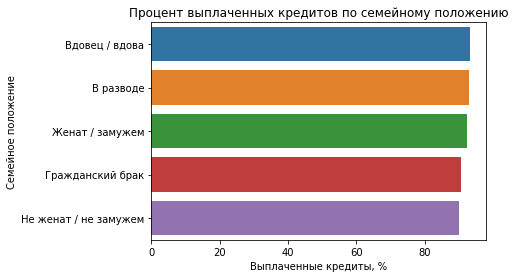

In [41]:
seaborn.barplot(y=['Вдовец / вдова', 'В разводе', 'Женат / замужем', 'Гражданский брак', 'Не женат / не замужем'], x=[93.4, 92.9, 92.5, 90.7, 90.2]);
plt.title('Процент выплаченных кредитов по семейному положению')
plt.xlabel('Выплаченные кредиты, %')
plt.ylabel('Семейное положение')

**Вывод**

По графику видно, процент выплаченных кредитов от семеного положения зависит следующим образом:
<br>
<br>
Вдовец / вдова - 93,4%
<br>
В разводе - 92,9%
<br>
Женат / замужем - 92,5%
<br>
Гражданский брак - 90,7%
<br>
Не женат / не замужем - 90,2%
<br>
<br>
- Предположу, что вдовцы и вдовы имея как правило большой жизненный опыт, берут кредиты более ответственно четко понимая смогут ли они их выплатить. Плюс как правило это люди в возрасте, имеющие определенные денежные наколения.
<br>
- С людьми находящимися в разводе, практически такая же ситуация - им приходится расчитывать только на себя.
<br>
- Семьи, находящиеся в браке могут иметь непредвиденные расходы из-за наличия детей и других причин, которые могут повлиять на возможность выплатить кредит в срок.
<br>
- Не состоящие в браке люди могут брать необдуманные кредиты, переоценивая свои возможности, так как уровень ответственности у них самый низкий.

**Есть ли зависимость между уровнем дохода и возвратом кредита в срок?**

Сведу полученные данные в таблицу для наглядности.

In [42]:
data_income = deepcopy(data_new)
data_income.rename(columns={'total_income_cat': 'Категория дохода', 'debt': 'Всего долгов'}, inplace=True)
t_1 = pd.pivot_table(data_income, index='Категория дохода', values='Всего долгов', aggfunc='count')
t_2 = pd.pivot_table(data_income, index='Категория дохода', values='Всего долгов', aggfunc='sum')
dept_income = t_1
dept_income['Не выплачено долгов'] = t_2['Всего долгов']
dept_income['Выплачено долгов'] = dept_income['Всего долгов'] - dept_income['Не выплачено долгов']
dept_income['Процент выплаченных долгов'] = dept_income['Выплачено долгов'] / dept_income['Всего долгов']
dept_income['Процент выплаченных долгов'] = dept_income['Процент выплаченных долгов'].mul(100).round(1).astype(str).add('%')
dept_income = dept_income.sort_values(by='Процент выплаченных долгов', ascending=False) 
display(dept_income)

,Всего долгов,Не выплачено долгов,Выплачено долгов,Процент выплаченных долгов
Категория дохода,,,,
доход от 250 тысяч,2813,194,2619,93.1%
доход от 200 до 250 тысяч,2254,164,2090,92.7%
доход до 100 тысяч,4463,354,4109,92.1%
доход от 150 до 200 тысяч,4764,405,4359,91.5%
доход от 100 до 150 тысяч,7160,624,6536,91.3%


Составлю график по процентам выплаченных долгов.

Text(0, 0.5, 'Уровень дохода')

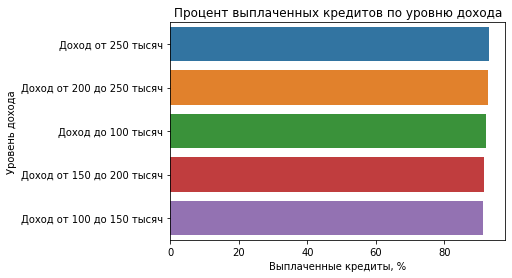

In [43]:
seaborn.barplot(y=['Доход от 250 тысяч', 'Доход от 200 до 250 тысяч', 'Доход до 100 тысяч', 'Доход от 150 до 200 тысяч', 'Доход от 100 до 150 тысяч'], x=[93.1, 92.7, 92.1, 91.5, 91.3]);
plt.title('Процент выплаченных кредитов по уровню дохода')
plt.xlabel('Выплаченные кредиты, %')
plt.ylabel('Уровень дохода')

**Вывод**

Проценты выплаченных кредитов по уровню дохода распределился следующим образом:
<br>
<br>
Доход от 250 тысяч - 93,1%
<br>
Доход от 200 до 250 тысяч - 92,7%
<br>
Доход до 100 тысяч - 92,1%
<br>
Доход от 150 до 200 тысяч - 91,5%
<br>
Доход от 100 до 150 тысяч - 91,3%
<br>
<br>
- Проценты выплаченных кредитов по уровню дохода ожидаемо выше у тех, кто больше зарабатывает, что логично - чем больше свободных денег, тем вороятнее выплатить кредит в срок.
<br>
- Неожиданно в середине графика оказалась категория людей с доходом ниже 100000 рублей. Вероятно, люди с таким доходом ответственнее подходят к выбору кредита оценивая свои возможности по его погашению.

**Как разные цели кредита влияют на его возврат в срок?**

Сведу полученные данные в таблицу для наглядности.

In [44]:
data_purpose = deepcopy(data_new)
data_purpose.rename(columns={'purpose_cat': 'Цель кредита', 'debt': 'Всего долгов'}, inplace=True)
t_1 = pd.pivot_table(data_purpose, index='Цель кредита', values='Всего долгов', aggfunc='count')
t_2 = pd.pivot_table(data_purpose, index='Цель кредита', values='Всего долгов', aggfunc='sum')
dept_purpose = t_1
dept_purpose['Не выплачено долгов'] = t_2['Всего долгов']
dept_purpose['Выплачено долгов'] = dept_purpose['Всего долгов'] - dept_purpose['Не выплачено долгов']
dept_purpose['Процент выплаченных долгов'] = dept_purpose['Выплачено долгов'] / dept_purpose['Всего долгов']
dept_purpose['Процент выплаченных долгов'] = dept_purpose['Процент выплаченных долгов'].mul(100).round(1).astype(str).add('%')
dept_purpose = dept_purpose.sort_values(by='Процент выплаченных долгов', ascending=False) 
display(dept_purpose)

,Всего долгов,Не выплачено долгов,Выплачено долгов,Процент выплаченных долгов
Цель кредита,,,,
кредит на недвижимость,10176,740,9436,92.7%
кредит на свадьбу,2324,186,2138,92.0%
кредит на автомобиль,4941,445,4496,91.0%
кредит на образование,4013,370,3643,90.8%


Составлю график по процентам выплаченных долгов.

Text(0, 0.5, 'Цель кредита')

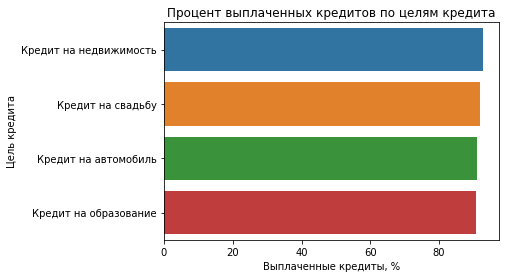

In [45]:
seaborn.barplot(y=['Кредит на недвижимость', 'Кредит на свадьбу', 'Кредит на автомобиль', 'Кредит на образование'], x=[92.7, 92.0, 91.0, 90.8]);
plt.title('Процент выплаченных кредитов по целям кредита')
plt.xlabel('Выплаченные кредиты, %')
plt.ylabel('Цель кредита')

**Вывод**

Проценты выплаченных кредитов по целям кредита распределился следующим образом:
<br>
<br>
Кредит на недвижимость - 92,7%
<br>
Кредит на свадьбу - 92,0%
<br>
Кредит на автомобиль - 91,0%
<br>
Кредит на образование - 90,8%
<br>
<br>
- Кредит на приобретение недвижимости, или различных манипуляций с недвижимостью имеет наивысший процент выплачиваемости, так как оформление кредита такого типа ответственный шаг и как правило при наличии рисков потерять возможность вносить выплаты, такой кредит не берут.
<br>
- Кредит на свадьбу имеет высокий процент выплат, так как он всегда берется с оглядкой на уровень дохода будущей семьи. Семья теряет возможность выплачивать данный тип кредита в случае форс-мажорных обстоятельст.
<br>
- Оставшиеся две позиции объединяет вероятность появления непредвиденных расходов в связи с приобретением (автомобиля, курсов повышения квалификации и пр.). К примеру дорогостоящая поломка автомобиля, отчисление с обучающих курсов и пр.

## Шаг 4. Общий вывод

По результатам проведенного исследования можно сказать следующее:
<br>
Зависимость между наличием детей и возвратом кредита в срок в самом благоприятном и наименее благоприятно случае, различается на 1,8%. Это одно из двух наименьших значений, поэтому обращать внимание на данную зависимость нужно после проверки более значимых зависимостей.
<br>
<br>
- Зависимость между семейным положением и возвратом кредита в срок в самом благоприятном и наименее благоприятно случае, различается на 3,2%. Это наибольшее значение, полученное в данном исследовании, поэтому при выдачи кредита на него нужно обращать наибольшее внимание.
<br>
- Зависимость между уровнем дохода и возвратом кредита в срок в самом благоприятном и наименее благоприятно случае, различается на 1,8%. Это второе из двух наименьших значений, поэтому обращать внимание на данную зависимость нужно после проверки более значимых зависимостей.
<br>
- Зависимость цели кредита и возвратом его в срок в самом благоприятном и наименее благоприятно случае, различается на 2,2%. Это второе по величине значение, полученное в данном исследовании. Поэтому на него также нужно обращать внимание при выдаче кредита.
<br>
- Выяснять закономерность по возрасту и по уровню образования в задачах исследования не требовалось.
<br>
<br>
В заключение укажу собирательный образ наиболее ответственного человека:
Вдовец без ребенка с доходом от 250000 рублей, берущий кредит на недвижимость.
<br>
Образ наименее ответственного человека:
Человек с 1-2 ребенком, находящийся в гржданском браке с доходом от 100000 до 150000 рублей, берущий кредит на автомобиль. 